# Part 1: How to Explore the GAN Latent Space When Generating Faces (25 pts)

1. Implement SR-GAN on your own using PyTorch. (Ref: https://arxiv.org/abs/1609.04802)

2. Use the ImageNet dataset to run a few epochs to train the model. You may use the script provided here to generate training data: Dataset (https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/srgan/datasets.py). However, there is some issue with this code, hence the drive link for the generated images is shared below. Please use this link to access the dataset for training SRGAN. (https://drive.google.com/drive/folders/13txSH8LU64amnvY0hkxMxMI6F6ssbErG?usp=sharing ) .

Note: you should only use this repo for dataset code and reference. Model and results
(20 pts) + report (5 pts)

In [1]:
! pip install pip install scikit-image

In [2]:
import glob
import random
import os
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms


# Configurations

In [3]:
! mkdir trained_model

mkdir: trained_model: File exists


In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "mps"

LOAD_MODEL = True
SAVE_MODEL = True

CHECKPOINT_GEN = "trained_model/gen.pth.tar"
CHECKPOINT_DISC = "trained_model/disc.pth.tar"

LEARNING_RATE = 1e-4
NUM_EPOCHS = 32
BATCH_SIZE = 16

HIGH_RES = 96
LOW_RES = HIGH_RES // 4
IMG_CHANNELS = 3


base_data_path = "./SRGAN_Data/"

# Data Loading And Transformation

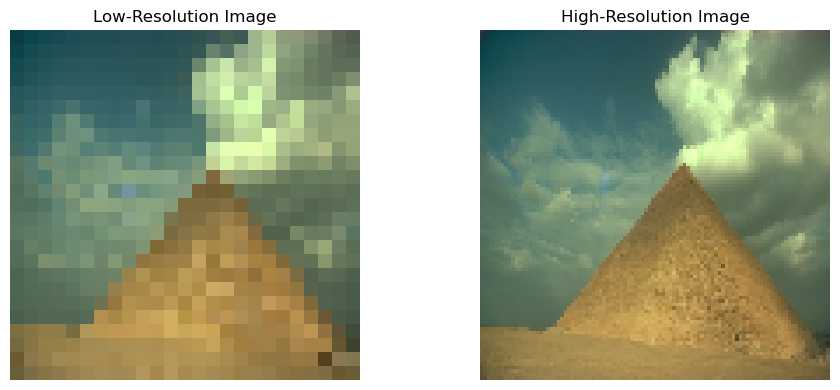

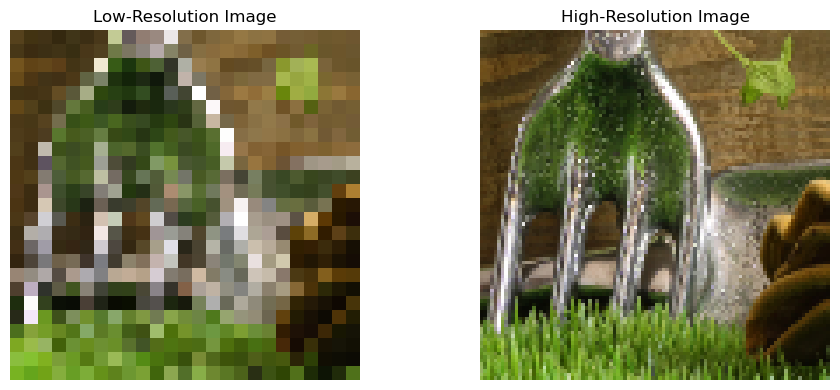

In [5]:
import matplotlib.pyplot as plt

def show_samples(data_path):
    lr_files = os.listdir(data_path + "/LR/")
    hr_files = os.listdir(data_path + "/HR/")
    
    
    for i in range(2):
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        image = Image.open(os.path.join(data_path + "/LR/", lr_files[i]))
        plt.imshow(image)
        plt.axis('off')
        plt.title('Low-Resolution Image')

        plt.subplot(1, 2, 2)
        image = Image.open(os.path.join(data_path + "/HR/", hr_files[i]))
        plt.imshow(image)
        plt.axis('off')
        plt.title('High-Resolution Image')
        
        plt.tight_layout()
        plt.show()        
        
show_samples(base_data_path)

In [6]:
low_res_image = os.listdir(base_data_path + "/LR/")[0]
print("Low Resolution Image size = ", Image.open(os.path.join(base_data_path + "/LR/", low_res_image)).size)

hish_res_image = os.listdir(base_data_path + "/HR/")[0]
print("High Resolution Image size = ", Image.open(os.path.join(base_data_path + "/HR/", hish_res_image)).size)

Low Resolution Image size =  (25, 25)
High Resolution Image size =  (100, 100)


In [7]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

class ImagePairDataset(Dataset):
    def __init__(self, root, hr_shape):
        hr_height, hr_width = hr_shape
        self.lr_transform = transforms.Compose([
            transforms.Resize((hr_height // 4, hr_height // 4), Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])
        self.hr_transform = transforms.Compose([
            transforms.Resize((hr_height, hr_height), Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])

        self.lr_files = sorted(glob.glob(root + "/LR/*.*"))
        self.hr_files = sorted(glob.glob(root + "/HR/*.*"))
        
        print(f"Number of low res images = {len(self.lr_files)}, and High res images = {len(self.hr_files)}")
        
        print("Image Sizes After transformation")
        print("Low Resolution Image size = ", self.lr_transform(Image.open(self.lr_files[0])).shape)
        print("High Resolution Image size = ", self.hr_transform(Image.open(self.hr_files[0])).shape)

    def __getitem__(self, index):
        img_lr = Image.open(self.lr_files[index])
        img_hr = Image.open(self.hr_files[index])

        img_lr = self.lr_transform(img_lr)
        img_hr = self.hr_transform(img_hr)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.lr_files)  # Each pair counts as one sample



dataset = ImagePairDataset(base_data_path, hr_shape=(96, 96))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"Data Load is created with size = {len(dataloader)}")

Number of low res images = 509, and High res images = 509
Image Sizes After transformation
Low Resolution Image size =  torch.Size([3, 24, 24])
High Resolution Image size =  torch.Size([3, 96, 96])
Data Load is created with size = 32


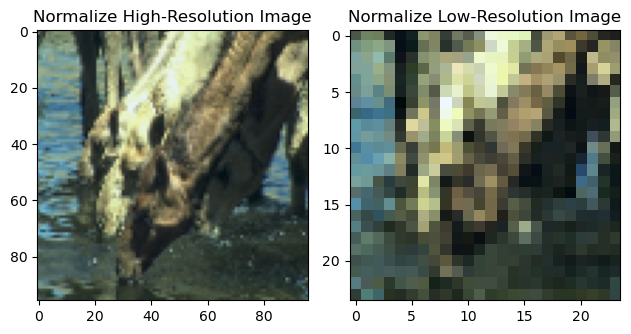

In [8]:
def normalize(img):
    return (img - img.min()) / (img.max() - img.min())

for data in dataloader:
    hr_img = data['hr']
    lr_img = data['lr']
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(normalize(hr_img[0].permute(1, 2, 0)))
    plt.title('Normalize High-Resolution Image')
    plt.subplot(1, 2, 2)
    plt.imshow(normalize(lr_img[0].permute(1, 2, 0)))
    plt.title('Normalize Low-Resolution Image')
    plt.tight_layout()
    plt.show()
    break

In [9]:


# from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize
# from math import log10

# def generated_output(G, image):
#     hr_ts = transforms.Compose([
#             transforms.Resize((96, 96), Image.BICUBIC),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=mean, std=std),
#         ])
    
#     lr_ts = transforms.Compose([
#             transforms.Resize((24, 24), Image.BICUBIC),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=mean, std=std),
#         ])
    
#     high_res_image = hr_ts(image).unsqueeze(0).to(DEVICE)
#     low_res_image = lr_ts(image).unsqueeze(0).to(DEVICE)
#     gen_output = G(low_res_image)
#     gen_output = (gen_output.squeeze().permute(1, 2, 0).cpu().detach().numpy() + 0)# * 0.5
#     return low_res_image, gen_output, high_res_image


# def evaluate_metrics(sr, hr):
#     sr = torch.from_numpy(sr).permute(2, 0, 1).unsqueeze(0).to(DEVICE)
#     mse = ((sr - hr) ** 2).data.mean()
#     ssim = 0
#     # ssim = pytorch_ssim.ssim(sr, hr).item()
#     psnr = 10 * log10((hr.max()**2) / mse)
#     print(f"{mse.item() = }, {ssim = }, {psnr = }")
#     return ssim, psnr

               
# def evaluate_test(image_file, G):
    
#     G.eval()
    
#     image = Image.open(image_file)
#     print(image.size)
#     image = CenterCrop(min(image.size))(image)
    
#     plt.figure(figsize=(15, 4))

    
# class TestDataset(Dataset):
#     def __init__(self, root, hr_shape):
#         hr_height, hr_width = hr_shape
#         self.lr_transform = transforms.Compose([
#             transforms.Resize((hr_height // 4, hr_height // 4), Image.BICUBIC),
#             transforms.ToTensor(),
#             transforms.Normalize(mean, std),
#         ])
#         self.hr_transform = transforms.Compose([
#             transforms.Resize((hr_height, hr_height), Image.BICUBIC),
#             transforms.ToTensor(),
#             transforms.Normalize(mean, std),
#         ])

#         self.files = sorted(glob.glob(root))
#         print(f"Number of low res images = {len(self.files)}")
#         print("Image Sizes After transformation")
#         print("Low Resolution Image size = ", self.lr_transform(Image.open(self.files[0])).shape)
#         print("High Resolution Image size = ", self.hr_transform(Image.open(self.files[0])).shape)

#     def __getitem__(self, index):
#         img = Image.open(self.files[index])
#         img = CenterCrop(min(image.size))(image)

#         img_lr = self.lr_transform(img)
#         img_hr = self.hr_transform(img)

#         return {"lr": img_lr, "hr": img_hr, "or": img.to}

#     def __len__(self):
#         return len(self.files)  # Each pair counts as one sample



# dataset = TestDataset(base_data_path, hr_shape=(96, 96))
# dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
# print(f"Data Load is created with size = {len(dataloader)}")

test_files = sorted(glob.glob(f"{base_data_path}/Test/*.*"))

# Model

![Image Title](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-19_at_11.13.45_AM_zsF2pa7.png)

In [10]:
import torch
from torch import nn


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation_func=None, normalize=True, bias=True, **kwargs):
        super().__init__()
        self.cnn = nn.Conv2d(in_channels, out_channels, bias=bias, **kwargs)
        self.batchNorm = nn.BatchNorm2d(out_channels) if normalize else nn.Identity()
        self.activation_func = activation_func
        

    def forward(self, x):
        out = self.cnn(x)
        out = self.batchNorm(out)
        if self.activation_func is not None:
            out = self.activation_func(out)
        return out


class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        # self.activation_func = nn.PReLU(num_parameters=in_channels)
        # first three layer of the residual block
        self.block_with_act = ConvBlock(in_channels, in_channels, kernel_size=3, stride=1, padding=1, activation_func=nn.PReLU(num_parameters=in_channels))
        # later 2 layer of the residual block
        self.block_wo_act = ConvBlock(in_channels, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        out = self.block_with_act(x)
        out = self.block_wo_act(out)
        return out + x


class PixelShufflerBlock(nn.Module):
    def __init__(self, in_channels, scale_factor):
        super().__init__()
        out_channels = in_channels * scale_factor ** 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1) # in_c * 4, H, W --> in_c, H*2, W*2
        self.bn = nn.BatchNorm2d(out_channels)
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)
        self.activation_function = nn.PReLU(num_parameters=in_channels)

    def forward(self, x):
        out = self.conv(x)
        out = self.pixel_shuffle(out)
        out = self.activation_function(out)
        return out


class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_res_blocks=16, num_pix_shuffle_blocks=2):
        super().__init__()
        self.first_layer = ConvBlock(in_channels, num_channels, activation_func=nn.PReLU(num_parameters=num_channels), kernel_size=9, stride=1, padding=4, normalize=False)
        self.residual_layer = nn.Sequential(*[ResidualBlock(num_channels) for _ in range(num_res_blocks)])
        self.conv_layer = ConvBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
        self.pixel_shuffle_layer = nn.Sequential(*[PixelShufflerBlock(num_channels, scale_factor=2) for _ in range(num_pix_shuffle_blocks)])
        self.output_layer = nn.Conv2d(num_channels, in_channels, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        initial = self.first_layer(x)
        out = self.residual_layer(initial)
        out = self.conv_layer(out) + initial
        out = self.pixel_shuffle_layer(out)
        out = self.output_layer(out)
        out = torch.tanh(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        activation_func = nn.LeakyReLU(0.2)
        self.layers = nn.Sequential(*[
            ConvBlock(in_channels, 64,  activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=1, padding=1, normalize=False),
            ConvBlock(64,  64,  activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=2, padding=1, normalize=True),
            ConvBlock(64,  128, activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=1, padding=1, normalize=True),
            ConvBlock(128, 128, activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=2, padding=1, normalize=True),
            ConvBlock(128, 256, activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=1, padding=1, normalize=True),
            ConvBlock(256, 256, activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=2, padding=1, normalize=True),
            ConvBlock(256, 512, activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=1, padding=1, normalize=True),
            ConvBlock(512, 512, activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=2, padding=1, normalize=True)
        ])

        self.conv_out = nn.Conv2d(512, 1, kernel_size=3, stride=1, padding=1) # The output is a feature map. We're using patch GAN here.

    def forward(self, x):
        
        out = self.layers(x)

        out = self.conv_out(out)
        
        return out


def test():
    x = torch.randn((5, 3, LOW_RES, LOW_RES))
    gen = Generator()
    gen_out = gen(x)
    print(gen_out.shape)
    disc = Discriminator()
    disc_out = disc(gen_out)
    print(disc_out.shape)


test()

torch.Size([5, 3, 96, 96])
torch.Size([5, 1, 6, 6])


In [11]:
from torchsummary import summary
print(Generator())
summary(Generator(), (3, 24, 24))

Generator(
  (first_layer): ConvBlock(
    (cnn): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (batchNorm): Identity()
    (activation_func): PReLU(num_parameters=64)
  )
  (residual_layer): Sequential(
    (0): ResidualBlock(
      (block_with_act): ConvBlock(
        (cnn): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchNorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation_func): PReLU(num_parameters=64)
      )
      (block_wo_act): ConvBlock(
        (cnn): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchNorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (block_with_act): ConvBlock(
        (cnn): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchNorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [12]:
print(Discriminator())
summary(Discriminator(), (3, 96, 96))

Discriminator(
  (layers): Sequential(
    (0): ConvBlock(
      (cnn): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchNorm): Identity()
      (activation_func): LeakyReLU(negative_slope=0.2)
    )
    (1): ConvBlock(
      (cnn): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (batchNorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_func): LeakyReLU(negative_slope=0.2)
    )
    (2): ConvBlock(
      (cnn): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchNorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_func): LeakyReLU(negative_slope=0.2)
    )
    (3): ConvBlock(
      (cnn): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (batchNorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_func): LeakyReLU(negative_slope=0

# VGG Loss

In [13]:
import torch.nn as nn
from torchvision.models import vgg19, VGG19_Weights

class TotalVariationLoss(nn.Module):
    def forward(self, x):
        batch_size = x.size()[0]
        h_x = x.size(2)
        w_x = x.size(3)
        count_h = x[:, :, 1:, :].numel() / batch_size
        count_w = x[:, :, :, 1:].numel() / batch_size
        h_tv = torch.pow((x[:, :, 1:, :] - x[:, :, :h_x - 1, :]), 2).sum()
        w_tv = torch.pow((x[:, :, :, 1:] - x[:, :, :, :w_x - 1]), 2).sum()
        return 2 * (h_tv / count_h + w_tv / count_w) / batch_size


class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = nn.Sequential(*list(vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features.children())[:31]).eval().to(DEVICE)
        self.loss = nn.MSELoss()

        for param in self.vgg.parameters():
            param.requires_grad = False
            
    def forward(self, preds, target):
        vgg_input_features = self.vgg(preds)
        vgg_target_features = self.vgg(target)
        return self.loss(vgg_input_features, vgg_target_features)

In [14]:
VGGLoss()

VGGLoss(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddi

# Utils Functions

In [15]:
import torch
import os
import numpy as np
from PIL import Image
from torchvision.utils import save_image


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print(f"=> Saving checkpoint {filename}")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    if os.path.exists(checkpoint_file):
        print("=> Loading checkpoint")
        checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
        model.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])

        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
    else:
        print("File does not exist.")
    
    return model, optimizer


# Training Evaluations

In [16]:
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize
from skimage.metrics import structural_similarity as ssim
from math import log10

def generated_output_for_test(G, image):
    hr_ts = transforms.Compose([
            transforms.Resize((96, 96), Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ])
    
    lr_ts = transforms.Compose([
            transforms.Resize((24, 24), Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ])
    
    high_res_image = hr_ts(image).unsqueeze(0).to(DEVICE)
    low_res_image = lr_ts(image).unsqueeze(0).to(DEVICE)
    gen_output = G(low_res_image)
    gen_output = (gen_output.squeeze().permute(1, 2, 0).cpu().detach().numpy() + 0)# * 0.5
    return low_res_image, gen_output, high_res_image


def evaluate_metrics(sr, hr):
    # ssim_index = 0
    print(type(sr), type(hr))
    sr1, hr1 = sr, hr.cpu().squeeze().permute(1, 2, 0).numpy()
    print(type(sr1), type(hr1))
    if len(sr1.shape) > 2:
        sr1 = np.mean(sr1, axis=-1)
    if len(hr1.shape) > 2:
        hr1 = np.mean(hr1, axis=-1)

    ssim_index = ssim(sr1, hr1, data_range=sr1.max() - sr1.min())
    # ssim = pytorch_ssim.ssim(sr, hr).item()
    
    sr = torch.from_numpy(sr).permute(2, 0, 1).unsqueeze(0).to(DEVICE)
    mse = ((sr - hr) ** 2).data.mean()
    

    psnr = 10 * log10((hr.max()**2) / mse)
    print(f"{mse.item() = }, {ssim_index = }, {psnr = }")
    return ssim_index, psnr
        

def evaluate_test_examples(test_files, G):
    eval_metrics = {"ssim": [], "psnr" : []}
    G.eval()
    for image_file in test_files:
        image = Image.open(image_file)
        image = CenterCrop(min(image.size))(image)
        low_res_image, generated_img, high_res_image = generated_output_for_test(G, image)
        ssim, psnr = evaluate_metrics(generated_img, high_res_image)
        # ssim, psnr = evaluate_test(f, G)
        eval_metrics["ssim"].append(ssim)
        eval_metrics["psnr"].append(psnr)
    return eval_metrics
        

In [17]:
import random
        
    
def generated_output(G, image):
    ts = transforms.Compose([
            transforms.Resize((24, 24), Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ])
    
    upscaled_img = ts(image).unsqueeze(0).to(DEVICE)
    gen_output = G(upscaled_img)
    gen_output = (gen_output.squeeze().permute(1, 2, 0).cpu().detach().numpy() + 1) * 0.5
    return upscaled_img, gen_output
    

def plot_examples(data_path, G):
    
    lr_files = os.listdir(data_path + "/LR/")
    hr_files = os.listdir(data_path + "/HR/")
    
    G.eval()
    for i in range(1):
        idx = random.randint(1, len(lr_files))
        plt.figure(figsize=(15, 4))
        
        plt.subplot(1, 4, 1)
        image = Image.open(os.path.join(data_path + "/LR/", lr_files[i]))
        plt.imshow(image)
        plt.axis('off')
        plt.title('Low-Resolution Image')

        transformed_lr, generated_img = generated_output(G, image)
        transformed_lr = (transformed_lr - transformed_lr.min()) / (transformed_lr.max() - transformed_lr.min())
        
        plt.subplot(1, 4, 2)
        plt.imshow(transformed_lr.squeeze().permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
        plt.title('Transformed Image')
        
        plt.subplot(1, 4, 3)
        plt.imshow(generated_img)
        plt.axis('off')
        plt.title('Generated Image')
        
        plt.subplot(1, 4, 4)
        image = Image.open(os.path.join(data_path + "/HR/", hr_files[i]))
        plt.imshow(image)
        plt.axis('off')
        plt.title('High-Resolution Image')
        
        plt.tight_layout()
        plt.show()       
        

# Training Model

In [18]:
import torch
# import config
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from tqdm import tqdm

torch.backends.cudnn.benchmark = True


def train_epoch(loader, D, G, opt_gen, opt_disc, mse_loss, gan_loss_func, vgg_loss_fun, tv_loss_func):
    
    training_metric = {"g_loss": [], "d_loss": [], "percp_loss": [], "l2_loss": [], "tv_loss": []}

    D.train()
    G.train()
    for batch, imgs in enumerate(loader):
        low_res = imgs['lr'].to(DEVICE)
        high_res = imgs['hr'].to(DEVICE)

        # Train Generator

        opt_gen.zero_grad()
        gen_high_res = G(low_res)
        disc_out = D(gen_high_res)

        g_adv_loss = gan_loss_func(disc_out, torch.ones_like(disc_out))
        percp_loss = vgg_loss_fun(gen_high_res, high_res)
        l2_loss = mse_loss(gen_high_res, high_res)
        tv_loss = tv_loss_func(gen_high_res)

        g_loss = l2_loss + 1e-3 * g_adv_loss + 6e-3 * percp_loss + 2e-8 * tv_loss

        g_loss.backward()
        opt_gen.step()

        # Train Discriminator
        opt_disc.zero_grad()
        disc_out_real = D(high_res)
        loss_real = mse_loss(disc_out_real, torch.ones_like(disc_out_real))

        disc_out_fake = D(gen_high_res.detach())
        loss_fake = mse_loss(disc_out_fake, torch.zeros_like(disc_out_fake))

        d_loss = (loss_real + loss_fake)

        d_loss.backward()
        opt_disc.step()

        
        if batch > 0 and batch % 10 == 0:
            print(f"\t{batch=}, g_loss: {g_loss.item()}, percp_loss: {percp_loss.item()}, l2_loss: {l2_loss.item()}, d_loss: {d_loss.item()}")
            training_metric["g_loss"].append(g_loss.item())
            training_metric["d_loss"].append(d_loss.item())
            training_metric["percp_loss"].append(percp_loss.item())
            training_metric["l2_loss"].append(l2_loss.item())
            training_metric["tv_loss"].append(tv_loss.item())

    return training_metric, D, G, opt_gen, opt_disc 

	batch=10, g_loss: 1.1218922138214111, percp_loss: 56.49552917480469, l2_loss: 0.7823238968849182, d_loss: 0.35799163579940796
	batch=20, g_loss: 1.2900362014770508, percp_loss: 50.81328201293945, l2_loss: 0.9844845533370972, d_loss: 0.15567249059677124
	batch=30, g_loss: 1.1580642461776733, percp_loss: 62.95281219482422, l2_loss: 0.7796410322189331, d_loss: 0.10011766850948334
./SRGAN_Data//Test/baby.png
(512, 512)
<class 'numpy.ndarray'> <class 'torch.Tensor'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
mse.item() = 0.7643585205078125, ssim_index = 0.2442716447531453, psnr = 9.599107634651808


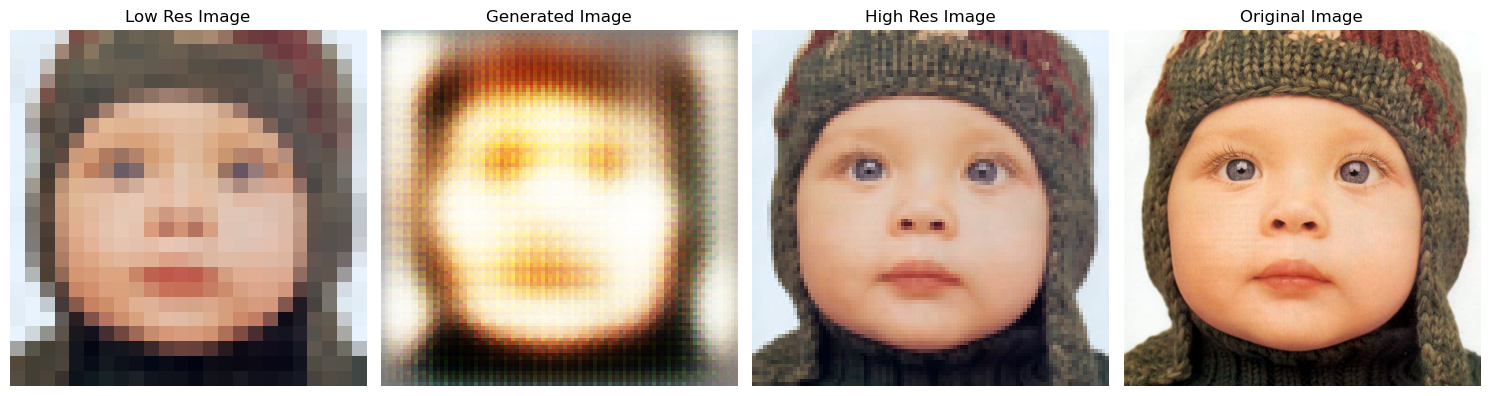

./SRGAN_Data//Test/bird.png
(288, 288)
<class 'numpy.ndarray'> <class 'torch.Tensor'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
mse.item() = 0.6736406683921814, ssim_index = 0.11191153620325582, psnr = 9.554549937947813


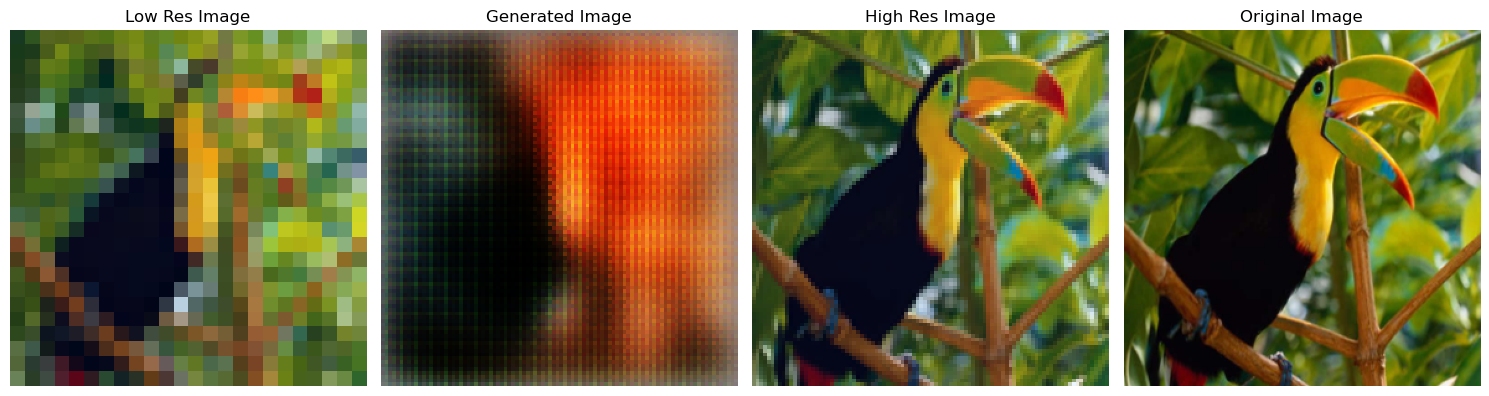

./SRGAN_Data//Test/butterfly.png
(256, 256)
<class 'numpy.ndarray'> <class 'torch.Tensor'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
mse.item() = 0.937160074710846, ssim_index = 0.017397398406937267, psnr = 7.670025161997392


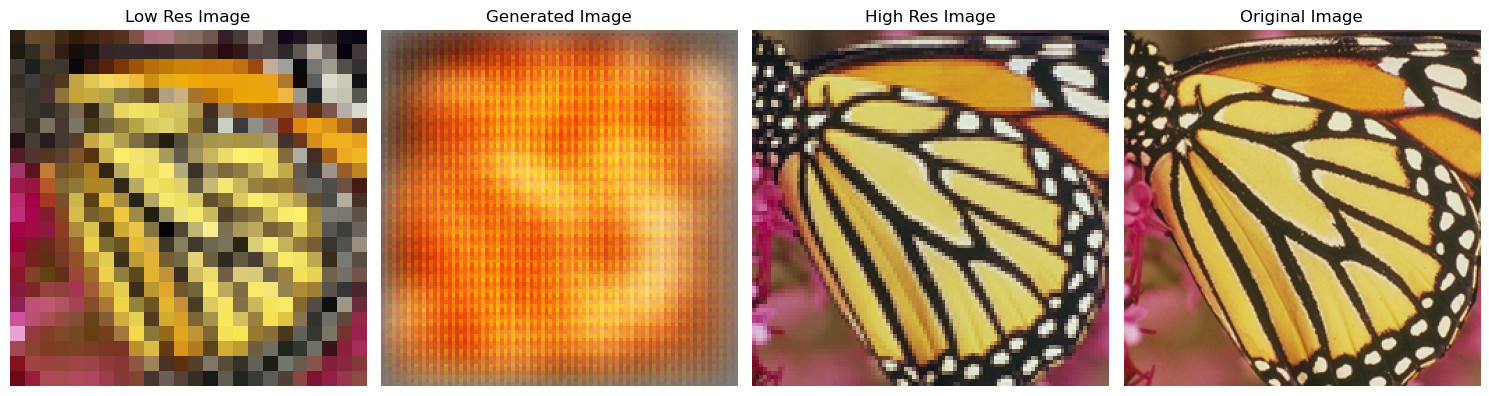

./SRGAN_Data//Test/head.png
(280, 280)
<class 'numpy.ndarray'> <class 'torch.Tensor'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
mse.item() = 0.5265311002731323, ssim_index = 0.2543303153367958, psnr = 11.102386301524351


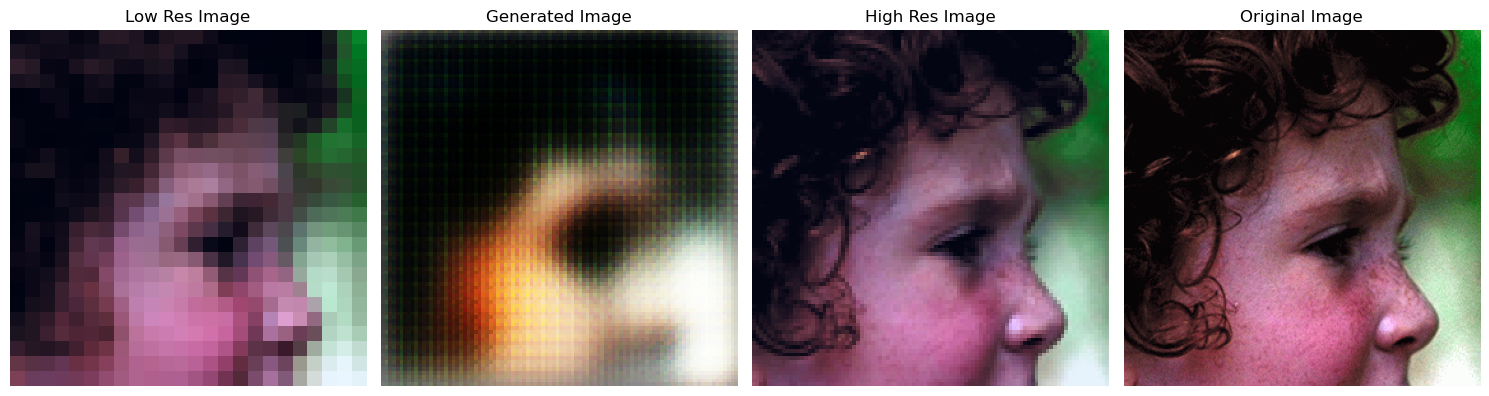

./SRGAN_Data//Test/woman.png
(224, 344)
<class 'numpy.ndarray'> <class 'torch.Tensor'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
mse.item() = 0.7269561886787415, ssim_index = 0.23667316189130272, psnr = 8.424352058119617


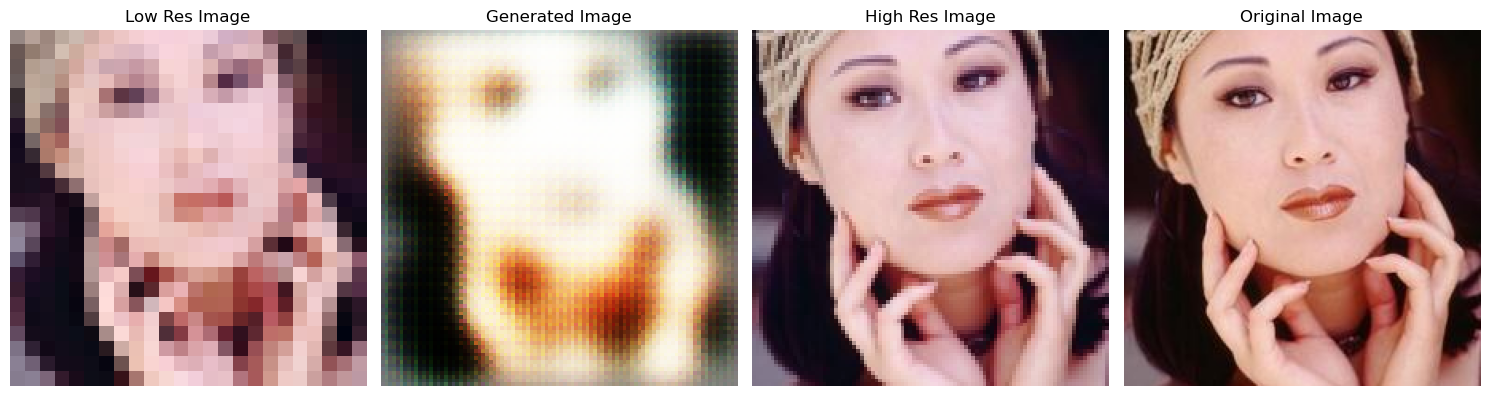


epoch = 0 {'g_loss': 1.1899975538253784, 'd_loss': 0.20459393163522085, 'percp_loss': 56.75387446085612, 'l2_loss': 0.8488164941469828, 'tv_loss': 0.045890228201945625, 'ssim': 0.17291681131828737, 'psnr': 9.270084218848195} 

=> Saving checkpoint trained_model/gen.pth.tar
=> Saving checkpoint trained_model/disc.pth.tar


ValueError: too many values to unpack (expected 2)

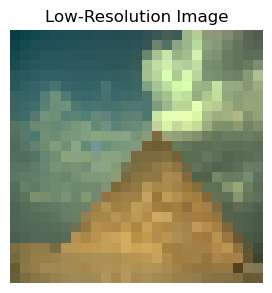

In [27]:
G = Generator().to(DEVICE)
G_optimizer = optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))

D = Discriminator().to(DEVICE)
D_optimizer = optim.Adam(D.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))


if False:
    load_checkpoint(CHECKPOINT_GEN, G, G_optimizer, LEARNING_RATE)
    load_checkpoint(CHECKPOINT_DISC, D, D_optimizer, LEARNING_RATE)
    print("Loaded Model Successfully")

training_metric = {"g_loss": [], "d_loss": [], "percp_loss": [], "l2_loss": [], "tv_loss": [], 
                   "ssim": [], "psnr": []}

for epoch in range(32):
    epoch_metric, D, G, G_optimizer, D_optimizer = train_epoch(dataloader, D, G, G_optimizer, D_optimizer, 
                                                               nn.MSELoss(), nn.BCEWithLogitsLoss(), VGGLoss(), TotalVariationLoss())

    for key in epoch_metric.keys():
        training_metric[key].append(np.mean(epoch_metric[key]))
    
    eval_metrics = evaluate_test_examples(test_files, G)
    for key in eval_metrics.keys():
        training_metric[key].append(np.mean(eval_metrics[key]))
    
    print(f"\n{epoch = }", {k: training_metric[k][-1] for k in training_metric.keys()}, "\n")
    
    if SAVE_MODEL:
        save_checkpoint(G, G_optimizer, filename=CHECKPOINT_GEN)
        save_checkpoint(D, D_optimizer, filename=CHECKPOINT_DISC)
    
    plot_examples(base_data_path, G)
    

# Model Evaluation

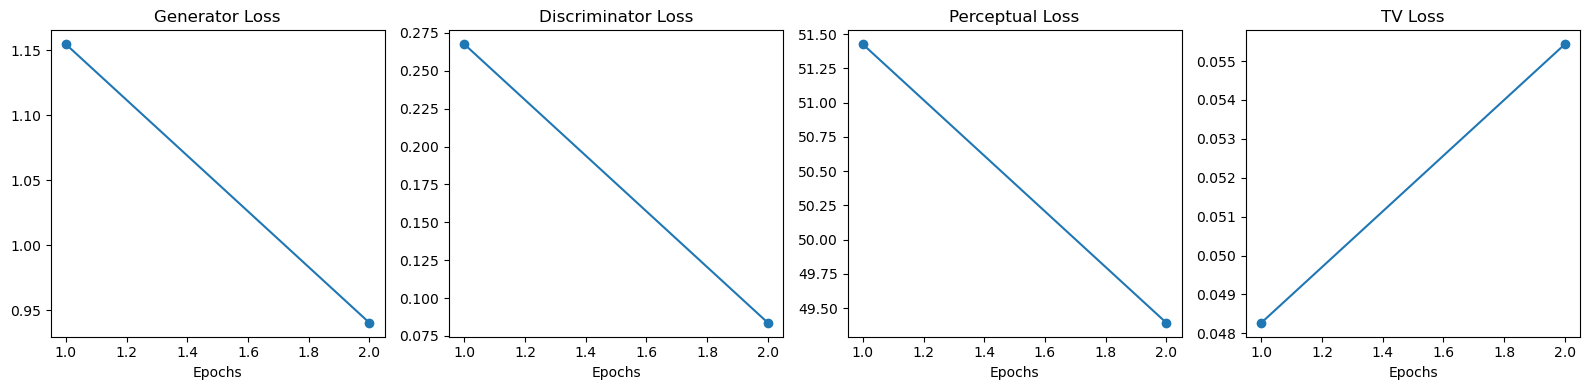

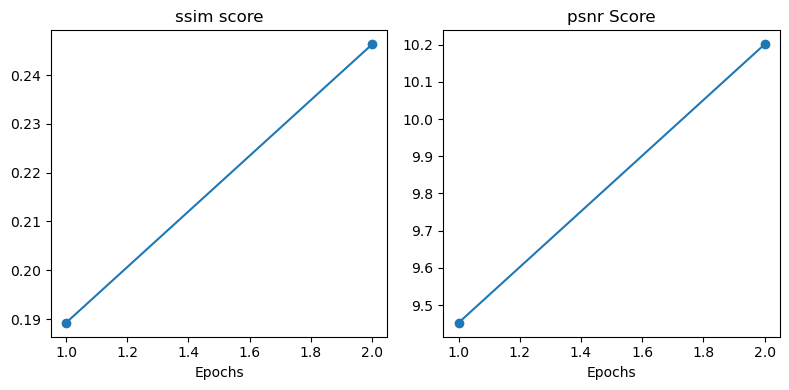

In [26]:
def plot_training_metrics(training_metric):
    num_epochs = len(training_metric['g_loss'])
    epochs = np.arange(1, num_epochs + 1)  # Assuming start from 1, adjust if needed

    # Plotting side by side without epoch axis
    fig, axs = plt.subplots(1, 4, figsize=(16, 4), dpi=100)

    # Plot g_loss
    axs[0].plot(epochs, training_metric['g_loss'], marker='o')
    axs[0].set_title('Generator Loss')
    axs[0].set_xlabel('Epochs')
    # axs[0].set_ylabel('Generator Loss')

    # Plot d_loss
    axs[1].plot(epochs, training_metric['d_loss'], marker='o')
    axs[1].set_title('Discriminator Loss')
    axs[1].set_xlabel('Epochs')
    # axs[1].set_ylabel('Discriminator Loss')

    # Plot vgg_loss
    axs[2].plot(epochs, training_metric['percp_loss'], marker='o')
    axs[2].set_title('Perceptual Loss')
    axs[2].set_xlabel('Epochs')
    # axs[2].set_ylabel('Perceptual Loss')

    axs[3].plot(epochs, training_metric['tv_loss'], marker='o')
    axs[3].set_title('TV Loss')
    axs[3].set_xlabel('Epochs')
    # axs[3].set_ylabel('TV Loss')

    # # Plot l2_loss
    # axs[3].plot(epochs, training_metric['l2_loss'], marker='o')
    # axs[3].set_title('L2 Loss')
    # axs[3].set_xlabel('Epochs')
    # axs[3].set_ylabel('Loss')
    plt.tight_layout()
    plt.show()
    
    
    # Plotting side by side without epoch axis
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=100)

    # Plot g_loss
    axs[0].plot(epochs, training_metric['ssim'], marker='o')
    axs[0].set_title('ssim score')
    axs[0].set_xlabel('Epochs')
    # axs[0].set_ylabel('Generator Loss')

    # Plot d_loss
    axs[1].plot(epochs, training_metric['psnr'], marker='o')
    axs[1].set_title('psnr Score')
    axs[1].set_xlabel('Epochs')
    # axs[1].set_ylabel('Discriminator Loss')
    plt.tight_layout()
    plt.show()
    
plot_training_metrics(training_metric)

In [21]:
# print("Showing Sample images generated by the model")
# plot_examples(base_data_path, G)

# Test Images

In [22]:
from skimage.metrics import structural_similarity as ssim


./SRGAN_Data//Test/baby.png
(512, 512)
<class 'numpy.ndarray'> <class 'torch.Tensor'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
mse.item() = 0.6029332280158997, ssim_index = 0.30304418619626733, psnr = 10.629386454402676


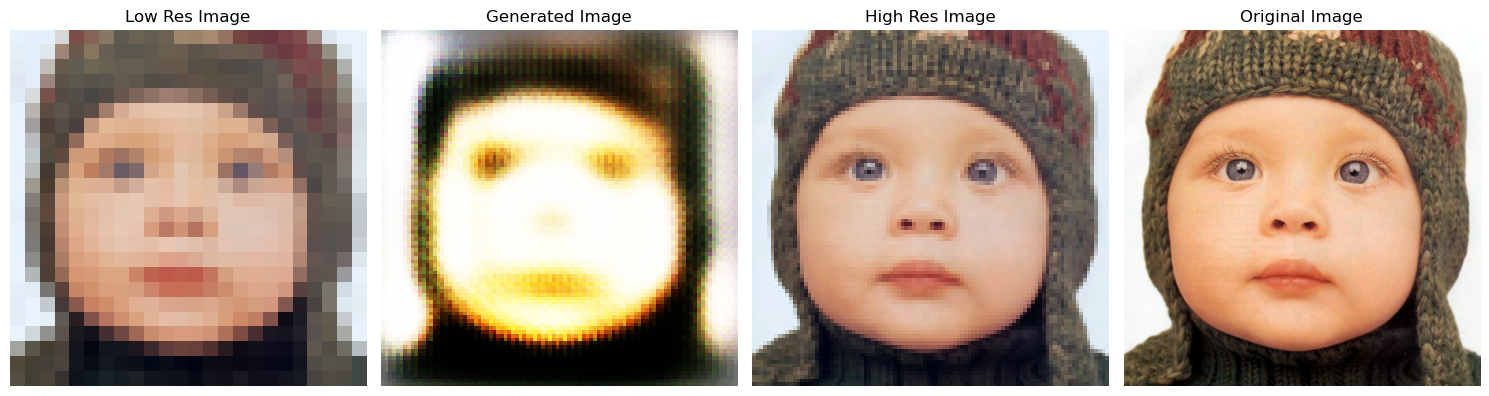

./SRGAN_Data//Test/bird.png
(288, 288)
<class 'numpy.ndarray'> <class 'torch.Tensor'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
mse.item() = 0.5459412932395935, ssim_index = 0.16646036467716818, psnr = 10.46737317655704


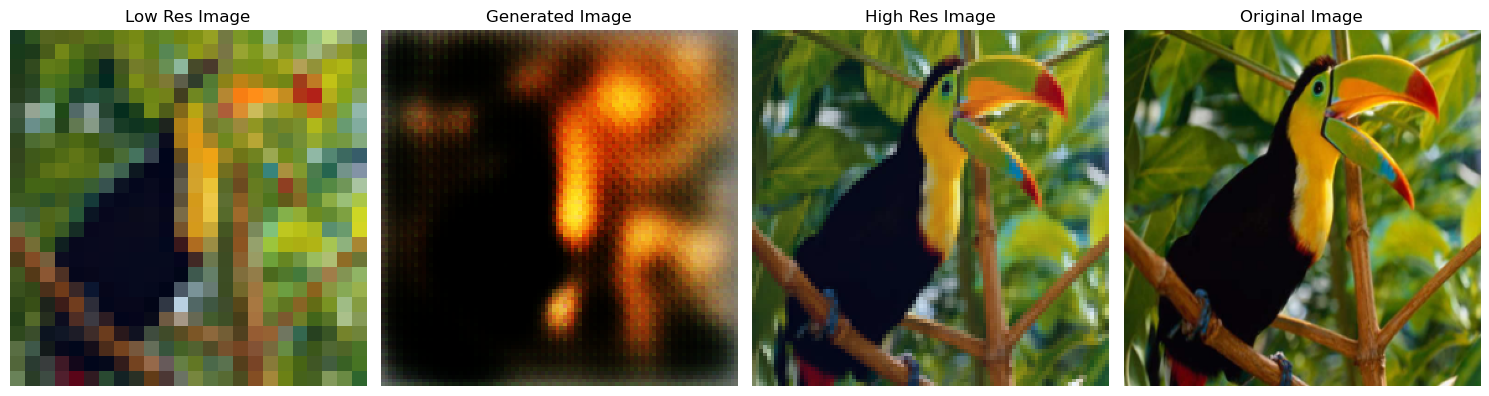

./SRGAN_Data//Test/butterfly.png
(256, 256)
<class 'numpy.ndarray'> <class 'torch.Tensor'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
mse.item() = 0.8226905465126038, ssim_index = 0.08984160167805082, psnr = 8.235798024813093


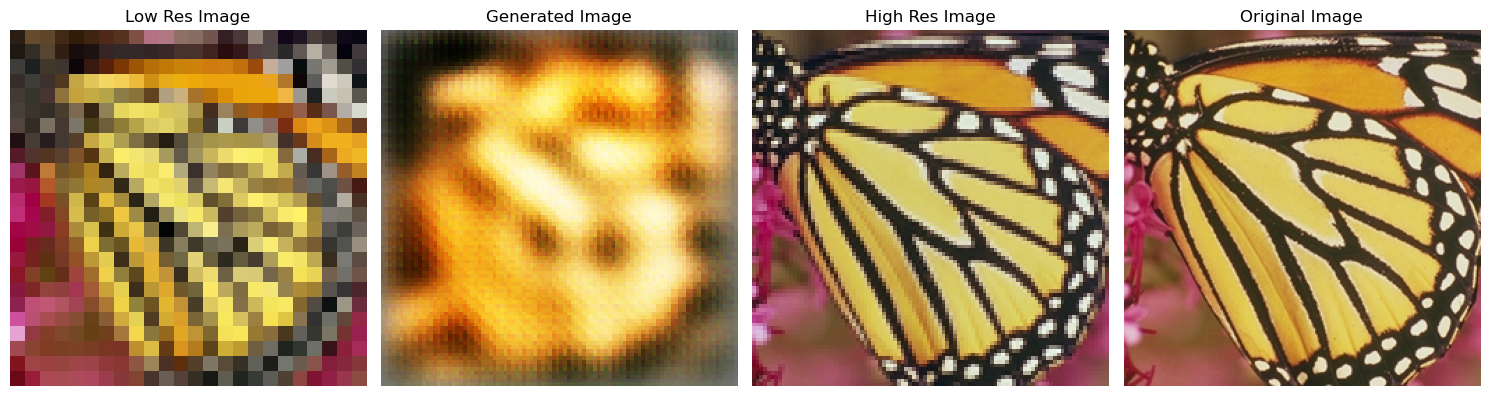

./SRGAN_Data//Test/head.png
(280, 280)
<class 'numpy.ndarray'> <class 'torch.Tensor'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
mse.item() = 0.4155445694923401, ssim_index = 0.3584160397485916, psnr = 12.130450712746143


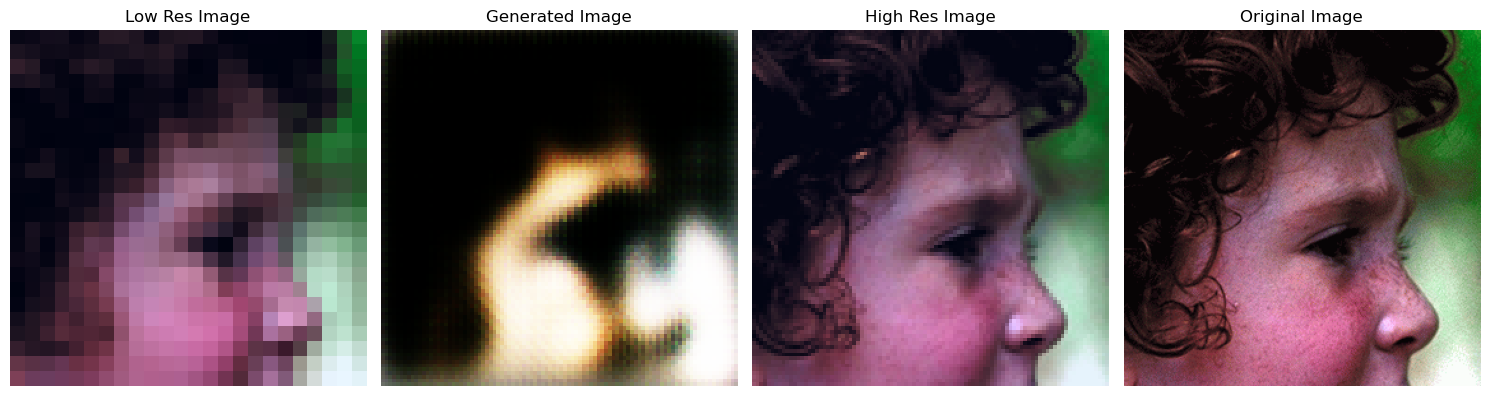

./SRGAN_Data//Test/woman.png
(224, 344)
<class 'numpy.ndarray'> <class 'torch.Tensor'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
mse.item() = 0.5619748830795288, ssim_index = 0.31373811259681517, psnr = 9.542265403795005


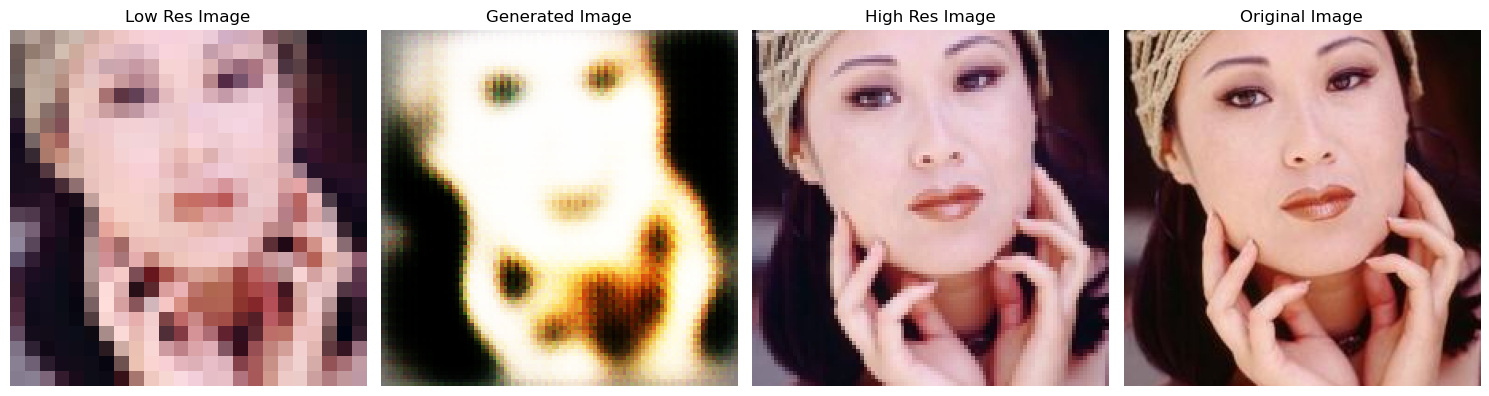

{'ssim': [0.30304418619626733,
  0.16646036467716818,
  0.08984160167805082,
  0.3584160397485916,
  0.31373811259681517],
 'psnr': [10.629386454402676,
  10.46737317655704,
  8.235798024813093,
  12.130450712746143,
  9.542265403795005]}

In [23]:
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize
from math import log10

def generated_output(G, image):
    hr_ts = transforms.Compose([
            transforms.Resize((96, 96), Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ])
    
    lr_ts = transforms.Compose([
            transforms.Resize((24, 24), Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ])
    
    high_res_image = hr_ts(image).unsqueeze(0).to(DEVICE)
    low_res_image = lr_ts(image).unsqueeze(0).to(DEVICE)
    gen_output = G(low_res_image)
    gen_output = (gen_output.squeeze().permute(1, 2, 0).cpu().detach().numpy() + 0)# * 0.5
    return low_res_image, gen_output, high_res_image


def evaluate_metrics(sr, hr):
    # ssim_index = 0
    sr1, hr1 = sr, hr.cpu().squeeze().permute(1, 2, 0).numpy()
    if len(sr1.shape) > 2:
        sr1 = np.mean(sr1, axis=-1)
    if len(hr1.shape) > 2:
        hr1 = np.mean(hr1, axis=-1)

    ssim_index = ssim(sr1, hr1, data_range=sr1.max() - sr1.min())
    # ssim = pytorch_ssim.ssim(sr, hr).item()
    
    sr = torch.from_numpy(sr).permute(2, 0, 1).unsqueeze(0).to(DEVICE)
    mse = ((sr - hr) ** 2).data.mean()
    

    psnr = 10 * log10((hr.max()**2) / mse)
    print(f"{mse.item() = }, {ssim_index = }, {psnr = }")
    return ssim_index, psnr

               
def evaluate_test(image_file, G):
    
    G.eval()
    
    image = Image.open(image_file)
    print(image.size)
    image = CenterCrop(min(image.size))(image)
    
    plt.figure(figsize=(15, 4))

    low_res_image, generated_img, high_res_image = generated_output(G, image)
    
    ssim, psnr = evaluate_metrics(generated_img, high_res_image)
    
    low_res_image = (low_res_image - low_res_image.min()) / (low_res_image.max() - low_res_image.min())
    plt.subplot(1, 4, 1)
    plt.imshow(low_res_image.squeeze().permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.title('Low Res Image')
    
    generated_img = (generated_img - generated_img.min()) / (generated_img.max() - generated_img.min())
    plt.subplot(1, 4, 2)
    plt.imshow(generated_img)
    plt.axis('off')
    plt.title('Generated Image')

    high_res_image = (high_res_image - high_res_image.min()) / (high_res_image.max() - high_res_image.min())

    plt.subplot(1, 4, 3)
    plt.imshow(high_res_image.squeeze().permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.title('High Res Image')

    
    plt.subplot(1, 4, 4)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Original Image')
    

    plt.tight_layout()
    plt.show()  
    
    return ssim, psnr
        

def evaluate_test_examples(files, G):
    eval_metrics = {"ssim": [], "psnr" : []}

    for f in files:
        print(f)
        ssim, psnr = evaluate_test(f, G)
        eval_metrics["ssim"].append(ssim)
        eval_metrics["psnr"].append(psnr)
    return eval_metrics
        
eval_metrics = evaluate_test_examples(test_files, G)
eval_metrics
